100%|██████████| 170498071/170498071 [00:02<00:00, 57782739.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [0/5] | D Loss: 0.6928067207336426 | G Loss: 0.768125057220459


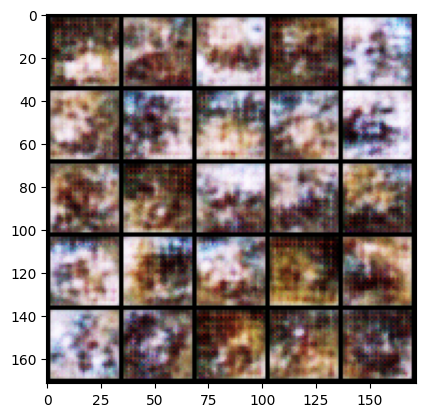

Epoch [1/5] | D Loss: 0.686775803565979 | G Loss: 0.7379632592201233
Epoch [2/5] | D Loss: 0.7103302478790283 | G Loss: 0.7007906436920166


In [ ]:
!pip install pytorch-fid
!pip install torchmetrics[image]


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm
from pytorch_fid import fid_score
from torchmetrics.image.inception import InceptionScore

# Self-Attention Block
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = spectral_norm(nn.Conv2d(in_dim, in_dim // 8, kernel_size=1))
        self.key_conv = spectral_norm(nn.Conv2d(in_dim, in_dim // 8, kernel_size=1))
        self.value_conv = spectral_norm(nn.Conv2d(in_dim, in_dim, kernel_size=1))
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        attention = torch.bmm(query, key)
        attention = torch.softmax(attention, dim=-1)
        value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

# Generator Network
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels):
        super(Generator, self).__init__()
        self.init_size = 8
        self.l1 = nn.Sequential(nn.Linear(z_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SelfAttention(128),
            spectral_norm(nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z).view(z.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            spectral_norm(nn.Conv2d(img_channels, 64, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(128),
            spectral_norm(nn.Conv2d(128, 128, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )
        # Use 128 * 4 * 4 if the image has been reduced to (4x4) after conv layers
        self.fc = spectral_norm(nn.Linear(128 * 4 * 4, 1))

    def forward(self, img):
        validity = self.conv_blocks(img)
        validity = self.fc(validity)
        return validity


# Initialize device and constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
lr = 2e-4
batch_size = 64
n_epochs = 5
img_channels = 3

# Initialize Generator and Discriminator
generator = Generator(z_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)
        real_loss = criterion(discriminator(imgs), torch.ones(imgs.size(0), 1).to(device))
        fake_loss = criterion(discriminator(fake_imgs.detach()), torch.zeros(fake_imgs.size(0), 1).to(device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), torch.ones(fake_imgs.size(0), 1).to(device))
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{n_epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

    # Generate and save images every few epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(25, z_dim).to(device)
            fake_imgs = generator(z)
            grid = vutils.make_grid(fake_imgs, nrow=5, normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.show()

# Generating 25 new images after training
z = torch.randn(25, z_dim).to(device)
fake_imgs = generator(z)

# Visualize generated images
grid = vutils.make_grid(fake_imgs, nrow=5, normalize=True)
plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
plt.show()

# Save generated images for FID score computation
vutils.save_image(fake_imgs, './generated_images/fake_images.png', normalize=True)

# Evaluation: FID and Inception Score
real_images_path = "./real_images"
fake_images_path = "./generated_images"

# Compute FID score
fid_value = fid_score.calculate_fid_given_paths([real_images_path, fake_images_path], batch_size, device)
print(f"FID: {fid_value}")

# Compute Inception Score
inception = InceptionScore()
IS_value = inception(fake_imgs)
print(f"Inception Score: {IS_value}")
